# Solving phase and frequency matching conditions computationally

Here, we use two similar approaches to find a set of solutions for a set of equations representing the restrictions on the frequencies for which nonlinear interaction occurs. These solutions may include several surfaces as solutions.

In [1]:
import sympy as sp
import numpy as np
import scipy.constants
from sympy.utilities.autowrap import ufuncify
import time
from scipy import interpolate

import matplotlib.pyplot as plt
%matplotlib inline

from sympy import init_printing
init_printing() 

import plotly.plotly as py
import plotly.graph_objs as go
import random

# import multiprocessing
# pool = multiprocessing.Pool()

In [2]:
## from https://www.andreas-jung.com/contents/a-python-decorator-for-measuring-the-execution-time-of-methods

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print '%r %2.2f sec' % \
              (method.__name__, te-ts)
        return result,te-ts
    return timed

In [3]:
def plot_arr(arr):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.asmatrix(arr), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()

In [4]:
## from http://refractiveindex.info/?shelf=main&book=LiNbO3&page=Zelmon-o

lambd,omega,omega1,omega2,omega3,omega4 = sp.symbols('lambda omega omega_1 omega_2 omega_3 omega_4')
l2 = lambd **2

def n_symb(pol='o'):
    s = 1.
    if pol == 'o':
        s += 2.6734 * l2 / (l2 - 0.01764)
        s += 1.2290 * l2 / (l2 - 0.05914)
        s += 12.614 * l2 / (l2 - 474.6)
    else:
        s += 2.9804 * l2 / (l2 - 0.02047)
        s += 0.5981 * l2 / (l2 - 0.0666)
        s += 8.9543 * l2 / (l2 - 416.08)
    return sp.sqrt(s)

def k_symb(symbol=omega,pol='o'):
    '''k is accurate for omega inputs between 6-60.'''
    return ((n_symb(pol=pol) * symbol )
                .subs(lambd,scipy.constants.c / (symbol*1e7))) ## / scipy.constants.c

In [9]:
phi1, phi2 = sp.symbols('phi_1 phi_2')

In [10]:
ex1 = (k_symb(omega1,pol='e')+k_symb(omega2,pol='e')).expand().subs({omega1:(phi1 + phi2)/2, omega2: (phi1-phi2)/2})

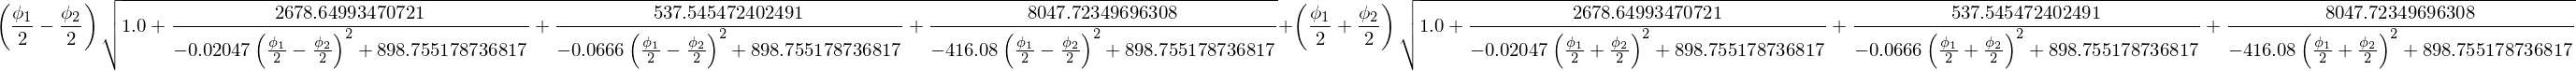

In [11]:
ex1

In [12]:
ex2 = -(k_symb(omega3,pol='e')+k_symb(omega4,pol='e')).expand().subs(omega4,-phi1-omega3)

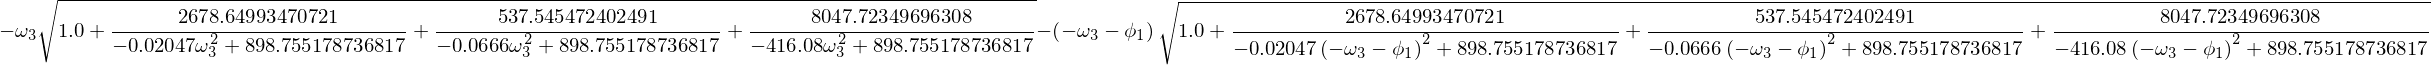

In [13]:
ex2

In [14]:
## We need to find where ex1(phi1,phi2) + ex2(phi1,omega3) = 0.

In [15]:
diff_func_4wv_1 = ufuncify([phi1,phi2], ex1)
diff_func_4wv_2 = ufuncify([phi1,omega3], ex2)

In [16]:
phi1_min = 30.
phi1_max = 34.

phi2_min = -13
phi2_max = -9

omega3_min = -26.
omega3_max = -16.

phi1_range = np.arange(phi1_min,phi1_max,0.01)
phi2_range = np.arange(phi2_min,phi2_max,0.01)
omega3_range = np.arange(omega3_min,omega3_max,0.01)

f_phi12_omega3 = lambda phi1,phi2,omega3 : (diff_func_4wv_1(phi1_range[phi1],phi2_range[phi2]) 
                                            - diff_func_4wv_2(phi1_range[phi1],omega3_range[omega3]) )

phi1_indices = range(len(phi1_range))
phi2_indices = range(len(phi2_range))

print len(phi1_range),len(phi2_range),len(omega3_range)

400 400 1000


In [ ]:
eps = 2e-4

In [17]:
def find_matching_elements_for_phi(phi1,ls1,ls2,z1,z2,matching_dict,eps=1e-4):
    '''
    Given a fixed phi1, do a single iteration through two sorted lists ls1 and ls2
    to find closely matching elements (within eps).
    
    Args:
        phi1 (int): index of fixed phi1
        ls1, ls2 (lists of floats): Sorted lists of values of functions f(phi1,phi2)
        and g(phi1,omega3) in the ranges of phi2, omega3
        z1,z2 (dicts): dictionaries from the lists ls1 and ls2 to the original index values
        of phi2 and omega3.
        matching_dict (dict): dict to which we add new entries. Keys are 3 incides, values 
        are error rates
    '''
    i = 0
    j = 0
    while i < len(ls1) and j < len(ls2):
        while ls2[j] > ls1[i] + eps and i < len(ls1)-1:
            i += 1
        k = i
        while k < len(ls1) and abs(ls1[k]-ls2[j]) < eps:
            matching_dict[phi1,z1[ls1[k]],z2[ls2[j]]] = abs(ls1[k]-ls2[j])
            k += 1
        j += 1
    i = 0
    j = 0
    while i < len(ls1) and j < len(ls2)-1:
        while ls2[j] + eps < ls1[i]  and j < len(ls2)-1:
            j += 1
        k = j
        while k < len(ls2) and abs(ls1[i]-ls2[k]) < eps:
            matching_dict[phi1,z1[ls1[i]],z2[ls2[k]]] = abs(ls1[i]-ls2[k])
            k += 1
        i += 1
    return

In [18]:
@timeit
def make_matching_dict(phi1_range,phi2_range,omega3_range,eps=5e-6):
    '''
    Make a dictionary mapping points close to solutions of a phase-matching condition
    to error values using sorted lists.
    
    Args:
        phi1_range (numpy array):
            list of phi1 values
        phi2_range (numpy array):
            list of phi2 values
        omega3_range (numpy array):
            list of omega3 values
        eps (optional[float]): 
            error allowed for phase-matching condition
    
    Returns:
        Dictionary (dict):
            dict mapping points to error values.
            
    '''
    matching_dict = {}
    for phi1_index,phi1 in enumerate(phi1_range):
        y1 = diff_func_4wv_1(phi1,phi2_range)
        y2 = diff_func_4wv_2(phi1,omega3_range)

        z1 = {e1:e2 for e1,e2 in zip(y1,range(len(phi2_range))) }
        z2 = {e1:e2 for e1,e2 in zip(y2,range(len(omega3_range))) }

        ls1 = sorted(y1)
        ls2 = sorted(y2)

        find_matching_elements_for_phi(phi1_index,ls1,ls2,z1,z2,matching_dict,eps=eps)
    return matching_dict

In [19]:
#####

In [20]:
def eps_multiply_digitize(y,eps):
    return  map(lambda el: int(el/eps), y)


def make_dict_values_to_lists_of_inputs(values,inputs):
    D = {}
    for k, v in zip(values,inputs):
        D.setdefault(k, []).append(v)
    return D

In [21]:
@timeit
def make_matching_dict_hash(phi1_range,phi2_range,omega3_range,eps=eps):
    '''
    Make a dictionary mapping points close to solutions of a phase-matching condition
    to error values using hash tables.
    
    Args:
        phi1_range (numpy array):
            list of phi1 values
        phi2_range (numpy array):
            list of phi2 values
        omega3_range (numpy array):
            list of omega3 values
        eps (optional[float]): 
            error allowed for phase-matching condition
    
    Returns:
        Dictionary (dict):
            dict mapping points to error values.

    '''
    phi2_indices = range(len(phi2_range))
    omega3_indices = range(len(omega3_range))
    matching_dict = {}
    for phi1_index,phi1 in enumerate(phi1_range):
        y1 = diff_func_4wv_1(phi1,phi2_range)
        y2 = diff_func_4wv_2(phi1,omega3_range)

        y1_rounded = eps_multiply_digitize(y1,eps)
        y1_rounded_up =  [ind + 1 for ind in y1_rounded]
        y2_rounded = eps_multiply_digitize(y2,eps)
        y2_rounded_up =  [ind + 1 for ind in y2_rounded]
                
        D1 = make_dict_values_to_lists_of_inputs(y1_rounded+y1_rounded_up,2*phi2_indices)
        D2 = make_dict_values_to_lists_of_inputs(y2_rounded+y2_rounded_up,2*omega3_indices)
            
        inter = set(D1.keys()) & set(D2.keys())
        
        for el in inter:
            for ind1 in D1[el]:
                for ind2 in D2[el]:
                    err = y1[ind1]-y2[ind2]
                    if abs(err) < eps:
                        matching_dict[phi1_index,ind1,ind2] = err 
        
    return matching_dict

In [22]:
#### e.g.

In [23]:
eps = 2e-4

In [36]:
## sorted list approach
matching_dict, t_ex = make_matching_dict(phi1_range,phi2_range,omega3_range,eps=eps)

'make_matching_dict' 15.56 sec


In [37]:
## hashing approach
matching_dict_hash, t_ex = make_matching_dict_hash(phi1_range,phi2_range,omega3_range,eps=eps)

'make_matching_dict_hash' 12.29 sec


In [38]:
len(matching_dict)

In [39]:
len(matching_dict_hash)

In [40]:
phi_12_omega3_arr = np.zeros((len(phi1_range),len(phi2_range)))

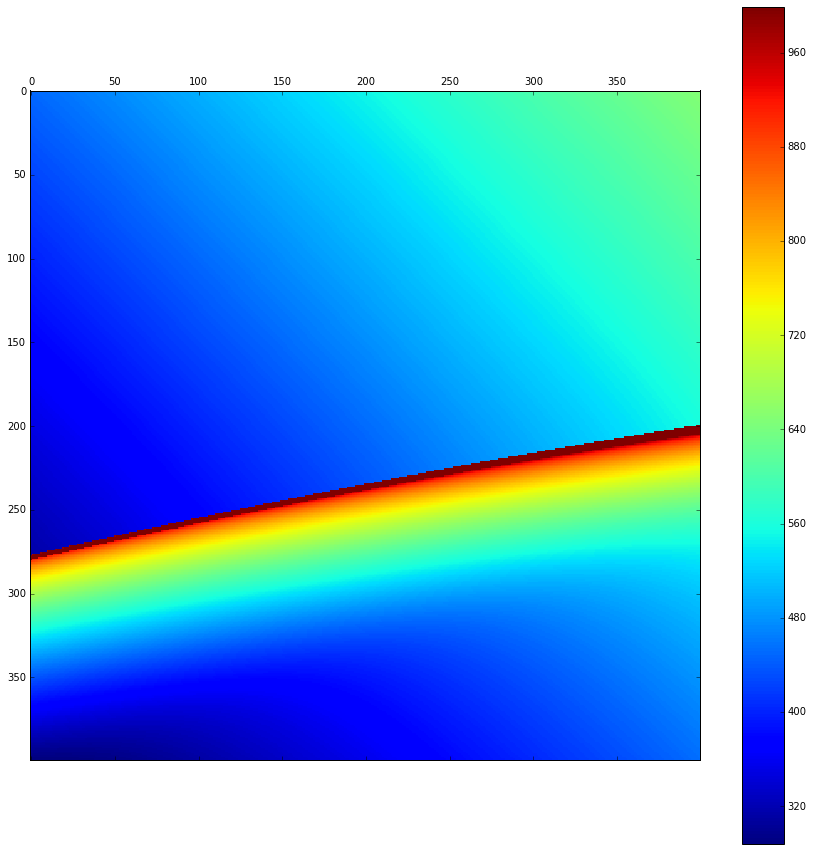

In [41]:
### maximum solution surface for sorted list approach

for key in matching_dict:
    if phi_12_omega3_arr[key[0],key[1]] < key[2]:
        phi_12_omega3_arr[key[0],key[1]] = key[2]
plot_arr(phi_12_omega3_arr)

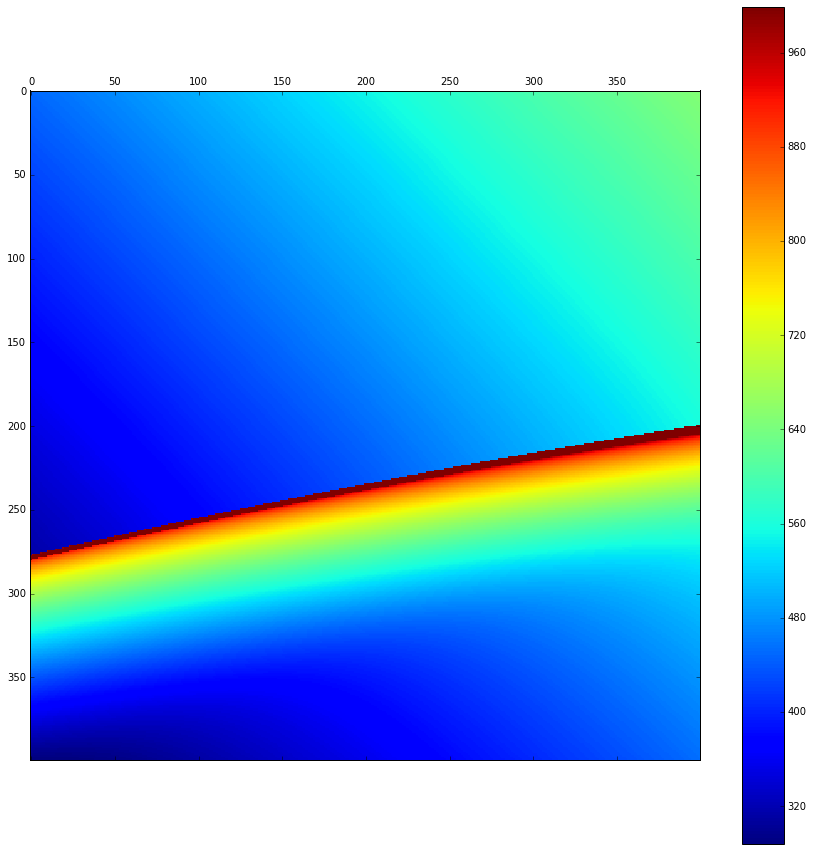

In [42]:
### maximum solution surface, hash approach

for key in matching_dict_hash:
    if phi_12_omega3_arr[key[0],key[1]] < key[2]:
        phi_12_omega3_arr[key[0],key[1]] = key[2]
plot_arr(phi_12_omega3_arr)

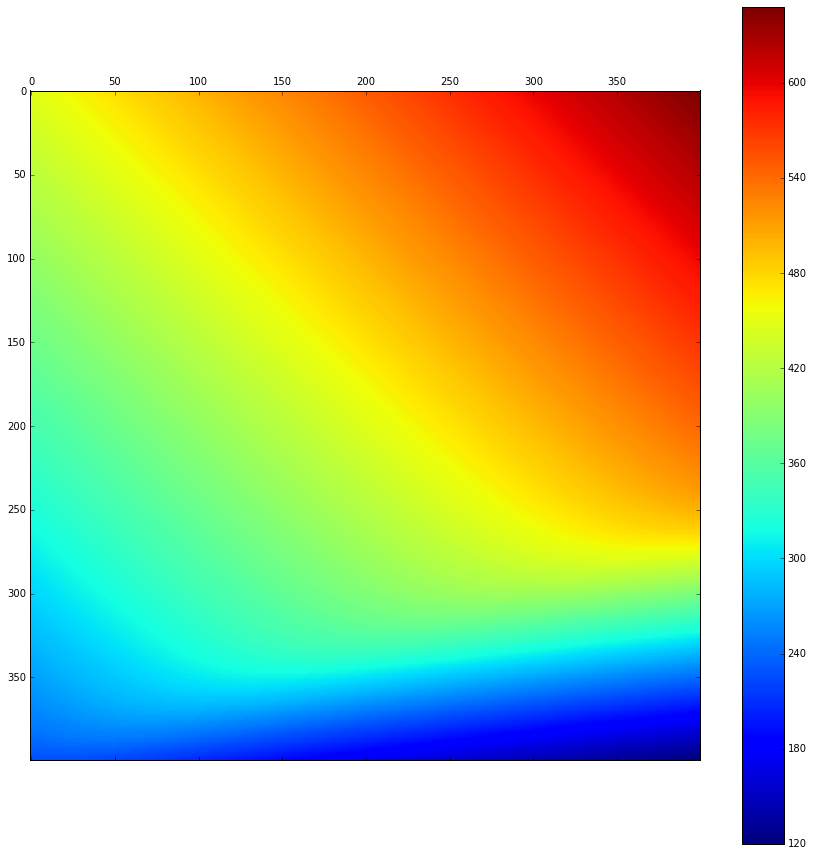

In [43]:
### minimum solution surface, sorted list approach

for key in matching_dict:
    if phi_12_omega3_arr[key[0],key[1]] != 0 and phi_12_omega3_arr[key[0],key[1]] > key[2]:
        phi_12_omega3_arr[key[0],key[1]] = key[2]
plot_arr(phi_12_omega3_arr)

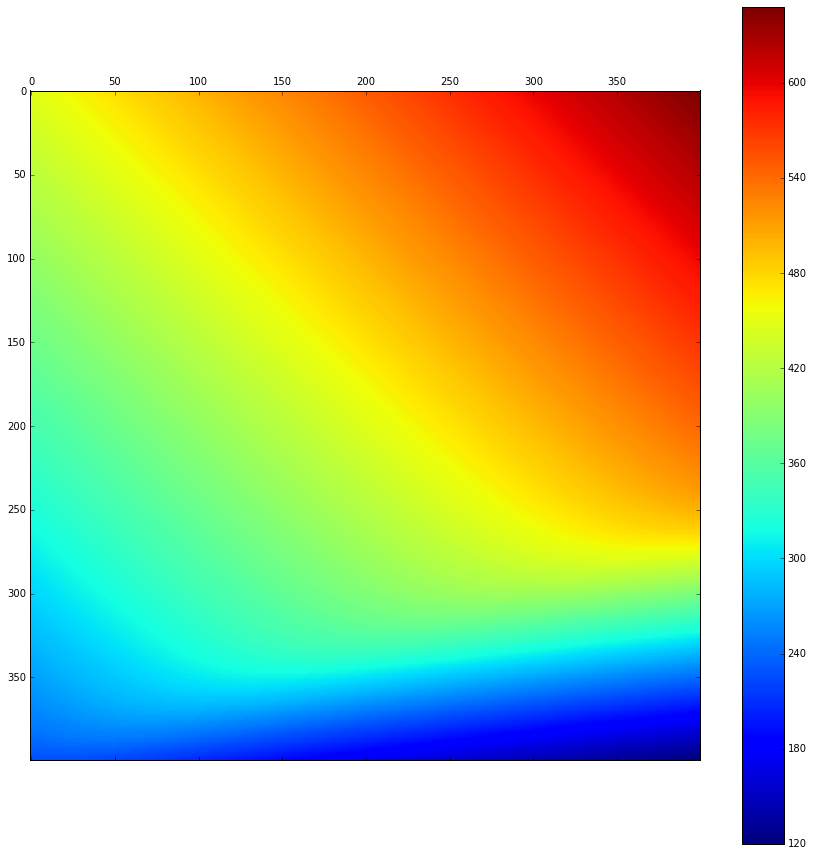

In [44]:
### minimum solution surface hash approach

for key in matching_dict_hash:
    if phi_12_omega3_arr[key[0],key[1]] != 0 and phi_12_omega3_arr[key[0],key[1]] > key[2]:
        phi_12_omega3_arr[key[0],key[1]] = key[2]
plot_arr(phi_12_omega3_arr)

In [517]:
surface_points = {}

for ind1 in phi1_indices:
    for ind2 in phi2_indices:
        surface_points[ind1,ind2] = []

for key in matching_dict:
    surface_points[key[0],key[1]].append(key[2])

In [518]:
def extract_intervals(ls,leeway = 1,c_max = 10000):
    '''
    Given an increasing sorted list of integers, find a list of closed intervals, each a
    containing only consecutive integers.
    
    Args:
        ls (list): an ascending list of integers.
        leeway (int): maximum skipping of numbers an interval can have
        c_max (int): max number of iterations
        
    Returns:
        A list of tuples representing closed intervals.
    '''
    i = 0
    j = 0
    c = 0
    intervals = []
    while i < len(ls) and c < c_max:
        c += 1
        if j < len(ls) and abs(ls[i]-ls[j]) <= leeway + abs(i-j):
            j += 1
        else:
            intervals.append((ls[i],ls[j-1]))
            i = j
    return intervals

In [519]:
i = 350
j = 350

In [520]:
sorted(surface_points[i,j])

In [521]:
intervals = extract_intervals(sorted(surface_points[i,j]) )

In [522]:
intervals

In [523]:
### points near solutions

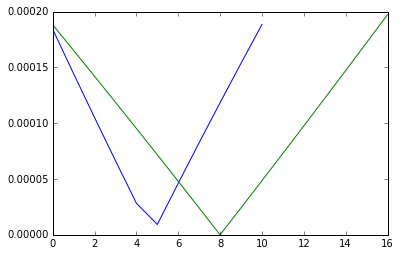

In [524]:
for inter in intervals:
    inter_plus_one_on_the_right = inter[0],inter[1]+1
    plt.plot(abs((f_phi12_omega3 (i,j,np.arange(*inter_plus_one_on_the_right)))))

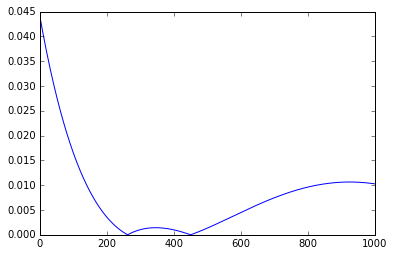

In [525]:
plt.plot(abs((f_phi12_omega3 (i,j,np.arange(0,1000)))))

## 3D plots

### Hashing solution

In [419]:
l = np.arange(0,len(matching_dict_hash)-1,1)
random.shuffle(l)
l=l[:30000]

x = np.zeros(len(matching_dict_hash))
y = np.zeros(len(matching_dict_hash))
z = np.zeros(len(matching_dict_hash))

for i,key in enumerate(matching_dict_hash):
    x[i] = key[0]
    y[i] = key[1]
    z[i] = key[2]

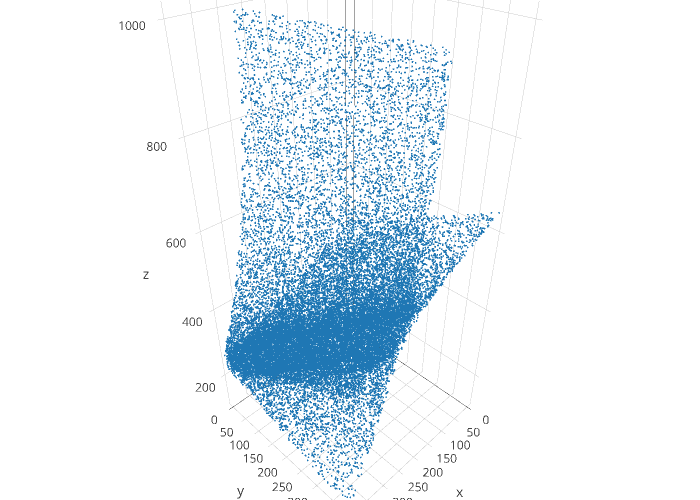

In [420]:
trace1 = go.Scatter3d(
    x=x[l],
    y=y[l],
    z=z[l],
    mode='markers',
    marker=dict(
        size=1,
        line=dict(),
        opacity=0.0
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='hashed solutions')

### Sorted list solution

In [421]:
l = np.arange(0,len(matching_dict),1)
random.shuffle(l)
l=l[:30000]

x = np.zeros(len(matching_dict))
y = np.zeros(len(matching_dict))
z = np.zeros(len(matching_dict))

for i,key in enumerate(matching_dict):
    x[i] = key[0]
    y[i] = key[1]
    z[i] = key[2]

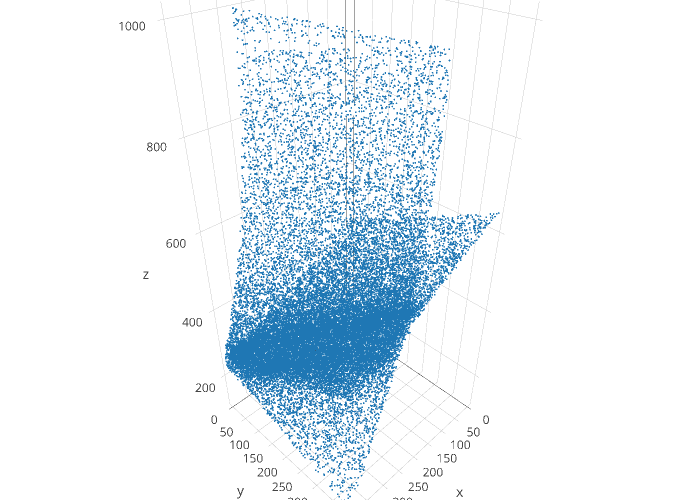

In [422]:
trace1 = go.Scatter3d(
    x=x[l],
    y=y[l],
    z=z[l],
    mode='markers',
    marker=dict(
        size=1,
        line=dict(),
        opacity=0.0
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='list solutions')

# Performance Comparison Between the two approaches

### What happens for different values of epsilon?

In [528]:
times_lists = {}
times_hashes = {}

In [531]:
eps_list = [1e-6,2e-6,5e-6,1e-5,2e-5,5e-5,1e-4,2e-4,3e-4,5e-4,1e-3]

In [532]:
for eps in eps_list:
    if not eps in times_lists.keys():
        matching_dict_test, t_ex_list = make_matching_dict(phi1_range,phi2_range,omega3_range,eps=eps)
        times_lists[eps] = t_ex_list
    if not eps in times_hashes.keys():
        matching_dict_test_hash, t_ex_hash = make_matching_dict_hash(phi1_range,phi2_range,omega3_range,eps=eps)
        times_hashes[eps] = t_ex_hash

'make_matching_dict_hash' 2.99 sec
'make_matching_dict' 1.91 sec
'make_matching_dict_hash' 2.89 sec
'make_matching_dict' 2.13 sec
'make_matching_dict_hash' 3.53 sec
'make_matching_dict' 2.65 sec
'make_matching_dict_hash' 2.84 sec
'make_matching_dict' 3.32 sec
'make_matching_dict_hash' 3.82 sec
'make_matching_dict' 6.30 sec
'make_matching_dict_hash' 5.12 sec
'make_matching_dict' 9.80 sec
'make_matching_dict_hash' 8.43 sec
'make_matching_dict' 16.44 sec
'make_matching_dict_hash' 10.91 sec
'make_matching_dict' 23.52 sec
'make_matching_dict_hash' 16.70 sec
'make_matching_dict' 34.36 sec
'make_matching_dict_hash' 23.75 sec
'make_matching_dict' 58.70 sec
'make_matching_dict_hash' 43.10 sec


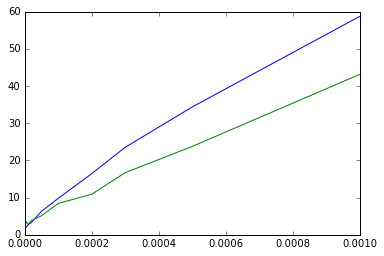

In [533]:
plt.plot(eps_list,[times_lists[eps] for eps in eps_list])
plt.plot(eps_list,[times_hashes[eps] for eps in eps_list])

The number of points increases about inversely with $\epsilon$. We see both approaches become linear time with the number of points, but the hash has smaller slope.

### Both approaches will be linear in $\phi_1$. What about $\phi_2$ and $\omega_3$?

In [36]:
eps = 6e-5

In [37]:
phi1_range = np.arange(phi1_min,phi1_max,0.01)
phi2_steps = [1./x for x  in np.linspace(5.,75.,8)]
omega3_steps = [1./x for x  in np.linspace(5.,75.,8)]

In [38]:
times_phi2_omega3_lists = np.zeros((len(phi2_steps),len(omega3_steps)))
times_phi2_omega3_hash = np.zeros((len(phi2_steps),len(omega3_steps)))

In [39]:
for i,stepsize_1 in enumerate(phi2_steps):
    for j,stepsize_2 in enumerate(omega3_steps):
        phi2_range = np.arange(phi2_min,phi2_max,stepsize_1)
        omega3_range = np.arange(omega3_min,omega3_max,stepsize_2)
        
        matching_dict_test, t_ex_list = make_matching_dict(phi1_range,phi2_range,omega3_range,eps=eps)
        times_phi2_omega3_lists[i,j] = t_ex_list
        
        matching_dict_test, t_ex_hash = make_matching_dict_hash(phi1_range,phi2_range,omega3_range,eps=eps)
        times_phi2_omega3_hash[i,j] = t_ex_hash

'make_matching_dict' 0.09 sec
'make_matching_dict_hash' 0.07 sec
'make_matching_dict' 0.19 sec
'make_matching_dict_hash' 0.17 sec
'make_matching_dict' 0.30 sec
'make_matching_dict_hash' 0.26 sec
'make_matching_dict' 0.42 sec
'make_matching_dict_hash' 0.43 sec
'make_matching_dict' 0.51 sec
'make_matching_dict_hash' 0.46 sec
'make_matching_dict' 0.64 sec
'make_matching_dict_hash' 0.60 sec
'make_matching_dict' 0.73 sec
'make_matching_dict_hash' 0.67 sec
'make_matching_dict' 0.83 sec
'make_matching_dict_hash' 0.83 sec
'make_matching_dict' 0.13 sec
'make_matching_dict_hash' 0.12 sec
'make_matching_dict' 0.28 sec
'make_matching_dict_hash' 0.24 sec
'make_matching_dict' 0.43 sec
'make_matching_dict_hash' 0.37 sec
'make_matching_dict' 0.59 sec
'make_matching_dict_hash' 0.56 sec
'make_matching_dict' 0.81 sec
'make_matching_dict_hash' 0.64 sec
'make_matching_dict' 0.98 sec
'make_matching_dict_hash' 0.89 sec
'make_matching_dict' 1.11 sec
'make_matching_dict_hash' 1.05 sec
'make_matching_dict' 1.30

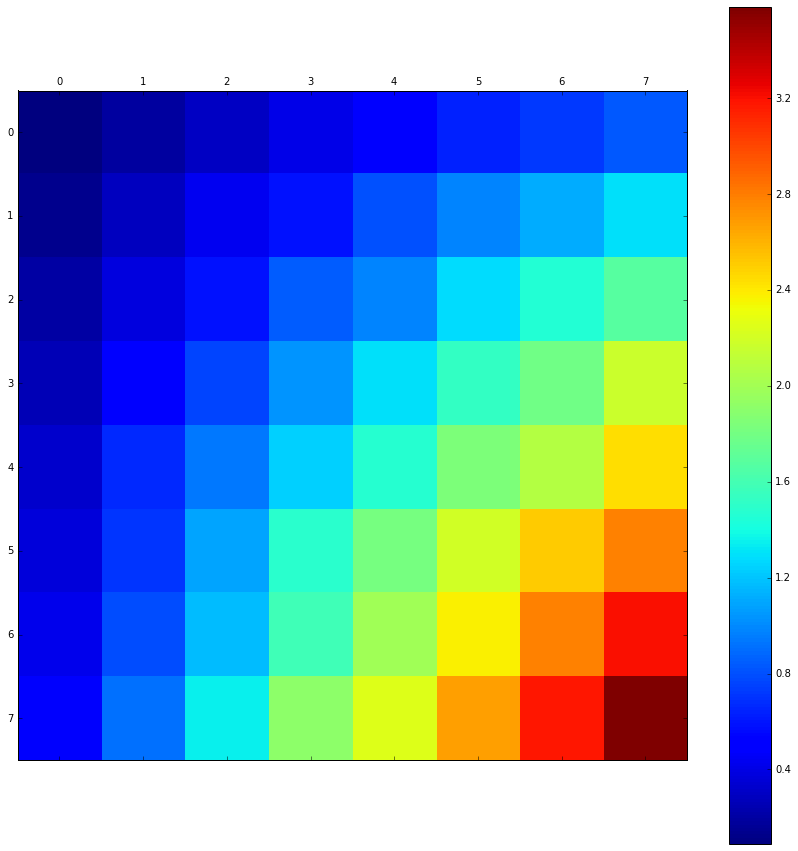

In [40]:
plot_arr(times_phi2_omega3_lists)

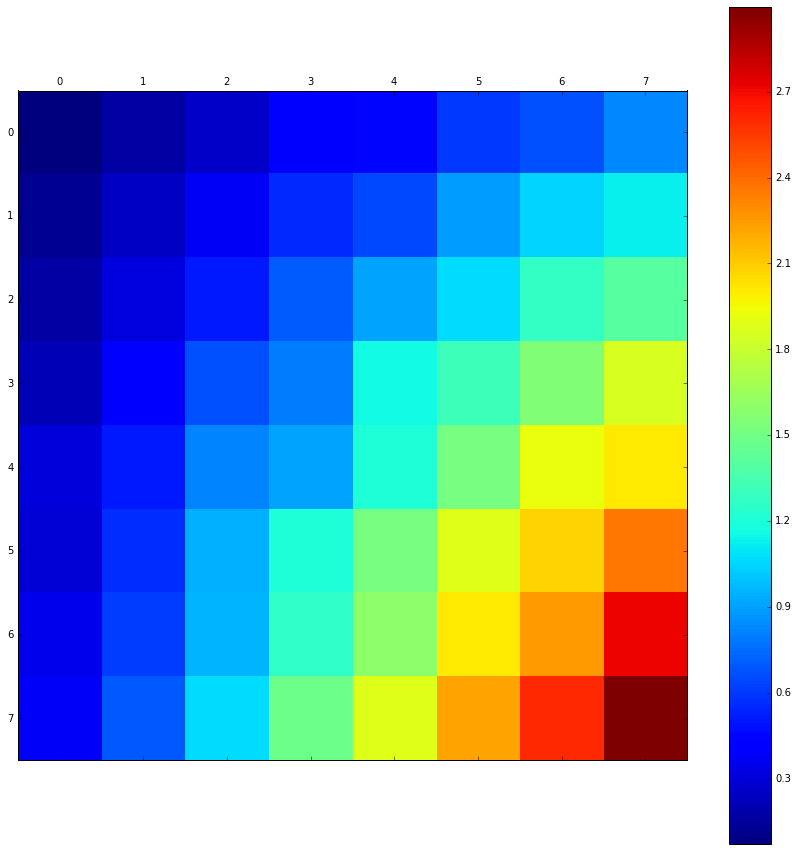

In [41]:
plot_arr(times_phi2_omega3_hash)

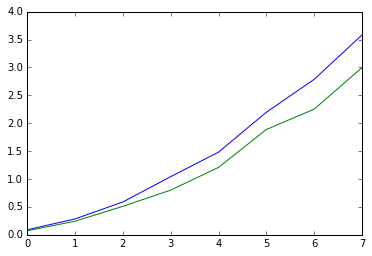

In [42]:
## Let's look along phi2 = omega3
plt.plot([times_phi2_omega3_lists[i,i] for i in range(8)])
plt.plot([times_phi2_omega3_hash[i,i] for i in range(8)])

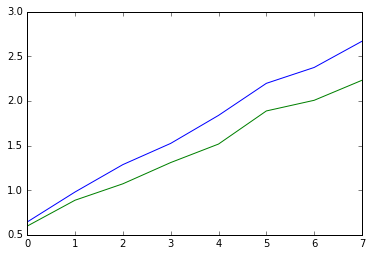

In [43]:
## Along constant omega3
plt.plot([times_phi2_omega3_lists[i,5] for i in range(8)])
plt.plot([times_phi2_omega3_hash[i,5] for i in range(8)])

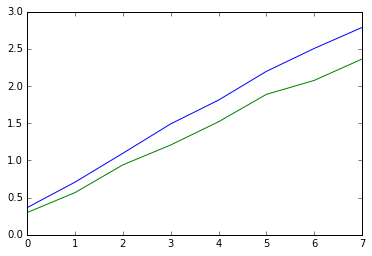

In [44]:
## Along constant phi2
plt.plot([times_phi2_omega3_lists[5,i] for i in range(8)])
plt.plot([times_phi2_omega3_hash[5,i] for i in range(8)])